In [1]:
import sys, os
from pathlib import Path
import ee
from joblib import Memory
from google.cloud import storage

sys.path.append(os.path.abspath(".."))
# Resolve all data paths relative to the repo root
REPO_ROOT = Path(__file__).resolve().parents[1] if "__file__" in globals() else Path.cwd().parents[0]

from config import load_config
from gee_utils import (
    init_gee,  
    load_image_collection,
    # Vector workflow functions
    create_parcel_shapefile,
    upload_shapefile_to_gcs,
    ingest_table_to_gee,
    reduce_regions_to_gcs,
    # Raster workflow functions (for reference)
    upload_raster_to_gcs,
    ingest_raster_to_gee,
)
from mappluto import load_and_sample
from geometry import get_city_geometry
from naip import calculate_spectral_indices
from raster_utils import rasterize_parcels
from analysis import (
    read_csv_from_gcs,
    load_spectral_stats,
    cluster_dataframe,
    analyze_cluster_composition,
)

In [2]:
# ===== RUN CONFIGURATION =====
CONFIG_FILE = "nyc_vacant.yaml"  # Change to "nyc_buildings", etc.
# =============================

memory = Memory(Path("cache"), verbose=0)

# Load run-specific config
CONFIG = load_config(CONFIG_FILE, config_dir=REPO_ROOT / "config")

# Create output directories
CONFIG.ensure_output_dirs(REPO_ROOT)

# gcs client
client = storage.Client()
bucket = client.bucket(CONFIG.gcp.bucket)

00:22:28 | INFO | vacant_lots | Loaded config for: nyc_vacant.yaml


In [3]:
init_gee(CONFIG.gcp)

00:22:30 | INFO | vacant_lots | Initializing GEE with ADC credentials and project:vacant-lot-detection
00:22:31 | INFO | vacant_lots | GEE sucessfully initialized


In [4]:
"""
- Load MapPLUTO (NYC) 2022 v3 -- fall matches with NAIP
- Reproject to output_crs (EPSG:32618) for geometry-derived metric area computation
- Filter by area: min from min_pixels × resolution², max from log +1σ of all parcels
- Sample vacant lots based on land use codes (configurable)
- Convert CRS: EPSG:32618 --> EPSG:4326 for GEE
"""
mappluto_22_gdf, sampled_gdf = load_and_sample(
    path=CONFIG.get_parcel_path(REPO_ROOT),
    layer=CONFIG.parcel.layer,
    land_use_codes=CONFIG.parcel.vacant_codes,
    col_to_sample=CONFIG.parcel.landuse_column,
    projected_crs=CONFIG.raster.output_crs,
    vacant_min_fraction=CONFIG.sampling.vacant_min_fraction,
    total_samples=CONFIG.sampling.total_samples,
    resolution=CONFIG.raster.resolution,
    min_pixels=CONFIG.sampling.min_pixels,
    random_state=CONFIG.sampling.random_state,
)

00:22:33 | INFO | vacant_lots | Loaded /Users/joyadebi/repos/Vacant_Lot_Detection/data/nyc_mappluto_22v3_arc_fgdb/MapPLUTO22v3.gdb
00:22:38 | INFO | vacant_lots | Computed area_m2_epsg32618 and geom_perimeter_epsg32618 in EPSG:32618
00:22:38 | INFO | vacant_lots | Area stats for entire dataset after converting to EPSG:32618:
 count    8.569980e+05
mean     6.846463e+02
std      2.268922e+04
min      2.466352e-05
25%      1.906708e+02
50%      2.444197e+02
75%      3.751528e+02
max      1.620962e+07
Name: area_m2_epsg32618, dtype: float64
00:22:39 | INFO | vacant_lots | min_area_m2: 50.0 m² (50 pixels × 1.0² m)  max_area_m2: 651.8 m² (Q3 + 1.5×IQR of parcels above min)
00:22:40 | INFO | vacant_lots | Resampling class 11: 0.023141530354424705 -> 0.08
00:22:41 | INFO | vacant_lots | Sampled sucessfully
00:22:41 | INFO | vacant_lots | Sampling LandUse 11 to 0.08
00:22:41 | INFO | vacant_lots | Converting CRS: EPSG:32618 --> EPSG:4326


/Users/joyadebi/repos/Vacant_Lot_Detection/mappluto.py:203: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_gdf = (gdf.groupby(landuse_col, group_keys=False).apply(lambda grp: grp.sample(n=min(target_per_class.get(grp.name,0), len(grp)), random_state=random_state)))


In [7]:
mappluto_22_gdf.shape

(856998, 96)

In [12]:
city_geom = get_city_geometry(CONFIG)

@memory.cache
def get_naip_for_city(config):
    return load_image_collection(
        collection_id=config.naip.collection_id,
        start_date=config.naip.start_date,
        end_date=config.naip.end_date,
        region=city_geom,
        mosaic=True
    )

naip = get_naip_for_city(CONFIG)
naip = calculate_spectral_indices(naip, CONFIG)

23:14:13 | INFO | vacant_lots | Loading geometry from TIGER counties: ['New York', 'Kings', 'Queens', 'Bronx', 'Richmond'] (state FIPS: 36)
23:14:13 | INFO | vacant_lots | Geometry loaded successfully
23:14:13 | INFO | vacant_lots | Loading ImageCollection: USDA/NAIP/DOQQ
23:14:13 | INFO | vacant_lots | Date range: 2022-01-01 → 2022-12-31
23:14:13 | INFO | vacant_lots | FilterBounds by region
23:14:14 | INFO | vacant_lots | Filtered collection contains 62 images
23:14:14 | INFO | vacant_lots | Creating mosaic from filtered collection
23:14:14 | INFO | vacant_lots | Mosaic created successfully
23:14:14 | INFO | vacant_lots | Clipping mosaiced image
23:14:14 | INFO | vacant_lots | scaling ['R', 'G', 'B', 'N'] by 255.0
23:14:14 | INFO | vacant_lots | calculating NDVI
23:14:14 | INFO | vacant_lots | scaling NDVI to [0,1]
23:14:14 | INFO | vacant_lots | calculating SAVI
23:14:14 | INFO | vacant_lots | clamping SAVI values [-1, 1]
23:14:14 | INFO | vacant_lots | scaling SAVI values to [0,1]


In [21]:
naip.projection().getInfo()

{'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}

# Rasterize Parcels

In [ ]:
# raster_output_path = CONFIG.get_raster_path(REPO_ROOT)
# intermediaries_dir = CONFIG.get_intermediaries_dir(REPO_ROOT)
# mapping_output_path = intermediaries_dir / "parcel_id_mapping.csv"

# raster_path, mapping_path = rasterize_parcels(
#     gdf=mappluto_22_gdf,
#     id_column=CONFIG.parcel.id_column,
#     raster_output_path=raster_output_path,
#     mapping_output_path=mapping_output_path,
#     crs=CONFIG.raster.output_crs,
#     resolution=CONFIG.raster.resolution,
#     overwrite=False,
# )

The following cell should only be run once when the raster needs to be uploaded to gcs and then ingested to gee

In [ ]:
# ## Upload parcel raster to GEE

# # Upload to GCS first
# gcs_uri = upload_raster_to_gcs(
#     raster_path=raster_path,
#     gcs_bucket=CONFIG.gcp.bucket,
#     gcs_prefix=CONFIG.gee.export_prefix,
#     gcs_filename="parcels_raster.tif",
# )

# # Ingest to GEE asset
# task_info = ingest_raster_to_gee(
#     gcs_uri=gcs_uri,
#     asset_id=CONFIG.gee.parcel_asset,
# )

# # Task runs asynchronously - check progress in Earth Engine Code Editor
# print(f"Task {task_info['task_id']} submitted")
# print(f"Check progress at: https://code.earthengine.google.com/tasks")

18:18:02 | INFO | vacant_lots | Uploading /Users/joyadebi/repos/Vacant_Lot_Detection/outputs/eda/nyc_vacant/rasters/parcels_epsg32618.tif to gs://thesis_parcels/eda/new_york_new_york/parcels_raster.tif
18:23:04 | INFO | vacant_lots | Raster upload to GCS complete
18:23:04 | INFO | vacant_lots | Ingesting raster from gs://thesis_parcels/eda/new_york_new_york/parcels_raster.tif to GEE asset: projects/vacant-lot-detection/assets/nyc_parcels_raster
18:23:04 | INFO | vacant_lots | Ingestion task started: CPG5WOEQOPL4YUZR5KWRVNBG
Task CPG5WOEQOPL4YUZR5KWRVNBG submitted
Check progress at: https://code.earthengine.google.com/tasks


## Raster-Based Parcel Reduction

Instead of using `reduceRegions()` with vector polygons (which is slow for many parcels), we can use a grouped reducer with the parcel raster. This approach:
1. Uploads the parcel raster to GEE as an Image asset
2. Stacks the imagery bands with the parcel ID band
3. Uses `reduceRegion()` with a grouped reducer to compute stats per parcel ID

Only upload to GEE when raster asset for a specific city needs to be overwritten. This is a time consuming process.

In [ ]:
# # Raster-based grouped reducer with ONLY sampled parcels
# from gee_utils import load_parcel_raster_asset, reduce_by_parcel_raster, export_grouped_stats_to_gcs
# import pandas as pd

# # Load parcel raster from GEE
# parcel_raster_asset = CONFIG.gee.parcel_asset
# parcel_raster = load_parcel_raster_asset(parcel_raster_asset)

# # Load the parcel_id mapping (BBL -> rasterized integer ID)
# mapping_path = CONFIG.get_intermediaries_dir(REPO_ROOT) / "parcel_id_mapping.csv"
# parcel_mapping = pd.read_csv(mapping_path)
# print(f"Loaded parcel mapping: {len(parcel_mapping)} parcels")

# # Get the rasterized IDs for sampled parcels only
# # Join sampled_gdf with mapping on BBL
# sampled_bbls = sampled_gdf['BBL'].astype(int).tolist()
# sampled_mapping = parcel_mapping[parcel_mapping['BBL'].isin(sampled_bbls)]
# sampled_parcel_ids = sampled_mapping['parcel_id'].tolist()
# print(f"Sampled parcels with mapping: {len(sampled_parcel_ids)}")

# # Verify bands
# print("NAIP bands:", naip.bandNames().getInfo())
# bands_to_reduce = ['R', 'G', 'B', 'N', 'NDVI', 'SAVI', 'Brightness', 'BareSoilProxy']

# naip_32618 = naip.reproject("EPSG:32618")
# # Run reduction with ONLY sampled parcel IDs
# grouped_stats = reduce_by_parcel_raster(
#     imagery=naip_32618,
#     parcel_raster=parcel_raster,
#     region=city_geom,
#     bands=bands_to_reduce,
#     scale=1,
#     debug=True,
#     parcel_ids=sampled_parcel_ids,  # Only process sampled parcels!
# )

# # Export results to GCS with new path structure
# task = export_grouped_stats_to_gcs(
#     stats_dict=grouped_stats,
#     description='parcel_spectral_stats_raster',
#     bucket=CONFIG.gcp.bucket,
#     file_prefix=f'{CONFIG.gee.export_prefix}/parcel_spectral_stats_raster',  # New path: eda/new_york_new_york/
# )

19:51:44 | INFO | vacant_lots | Loading parcel raster asset: projects/vacant-lot-detection/assets/nyc_parcels_raster
Loaded parcel mapping: 856998 parcels
Sampled parcels with mapping: 24992
NAIP bands: ['R', 'G', 'B', 'N', 'NDVI', 'SAVI', 'Brightness', 'BareSoilProxy']
19:51:44 | INFO | vacant_lots | Reducing imagery by parcel raster, bands: ['R', 'G', 'B', 'N', 'NDVI', 'SAVI', 'Brightness', 'BareSoilProxy'], scale: 1
19:51:44 | INFO | vacant_lots | Filtering parcel raster to 24992 sampled parcels
19:51:44 | INFO | vacant_lots | Parcel ID band index: 8
19:51:44 | INFO | vacant_lots | Parcel raster bands: ['b1']
19:51:45 | INFO | vacant_lots | Selected imagery bands: ['R', 'G', 'B', 'N', 'NDVI', 'SAVI', 'Brightness', 'BareSoilProxy']
19:51:45 | INFO | vacant_lots | Stacked bands: ['R', 'G', 'B', 'N', 'NDVI', 'SAVI', 'Brightness', 'BareSoilProxy', 'parcel_id']
19:51:46 | INFO | vacant_lots | Number of bands in stacked: 9
19:51:46 | INFO | vacant_lots | Grouped reduction complete
19:51:4

# Previous Vector based approach to reducing

In [9]:
## convert to .shp or .zip -> gcs -> gee table injestion
import geopandas as gpd
import zipfile 
from pathlib import Path

# Make minimal gdf copy with identifier to send as feature collection
minimal_gdf = sampled_gdf[["BBL", "geometry"]].copy()

# shp file does not like long ints, but can handle long text fields (254 chars)
minimal_gdf["BBL"] = minimal_gdf["BBL"].astype(str)

# Use config-based intermediaries directory
intermediaries_dir = CONFIG.get_intermediaries_dir(REPO_ROOT)
intermediaries_dir.mkdir(parents=True, exist_ok=True)

# write shapefile --> GEE can only injest .shp or .zip as table 11-30-2025
# https://developers.google.com/earth-engine/guides/table_upload 
shp_path = intermediaries_dir / f"{CONFIG.city}_parcels.shp"
minimal_gdf.to_file(shp_path)

# zip all shapefile component files (GEE needs all to render)
zip_path = intermediaries_dir / f"{CONFIG.city}_parcels.zip"
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as z:
    for file in intermediaries_dir.glob(f"{CONFIG.city}_parcels.*"):
        if file.suffix != ".zip":
            z.write(file, arcname=file.name)

print("Created:", zip_path.resolve())

blob = bucket.blob(f"{CONFIG.gee.export_prefix}/parcels.zip")
blob.upload_from_filename(zip_path)

Created: /Users/joyadebi/repos/Vacant_Lot_Detection/outputs/eda/nyc_vacant/intermediaries/nyc_parcels.zip


In [11]:
# ingest into ee as asset 

manifest = {
  'name': f'projects/{CONFIG.gcp.project_id}/assets/nyc_parcels',
  'sources': [
    {
      'uris': [
        f'gs://{CONFIG.gcp.bucket}/{CONFIG.gee.export_prefix}/parcels.zip'
      ]
    }
  ]
}

task = ee.data.startTableIngestion(None, manifest)

In [13]:
naip.bandNames().getInfo()

['R', 'G', 'B', 'N', 'NDVI', 'SAVI', 'Brightness', 'BareSoilProxy']

In [24]:
# load parcels from GEE (vector approach - kept for comparison)
parcels = ee.FeatureCollection(f"projects/{CONFIG.gcp.project_id}/assets/nyc_parcels")

reducer = (
    ee.Reducer.mean()
      .combine(ee.Reducer.median(), "", True)
      .combine(ee.Reducer.stdDev(), "", True)
      .combine(ee.Reducer.count(), "", True)
)

stats = naip.reduceRegions(
    collection=parcels,
    reducer=reducer,
    scale=1,            # NAIP is 1 m
    tileScale=4         # optional: helps avoid memory errors
)

task = ee.batch.Export.table.toCloudStorage(
    collection=stats,
    description='parcel_spectral_stats',
    bucket=CONFIG.gcp.bucket,
    fileNamePrefix=f'{CONFIG.gee.export_prefix}/parcel_spectral_stats',
    fileFormat='CSV'
)
task.start()

# NOTE: Consider using the raster-based approach below for better performance

## Start here to get the Parcel by Parcel Spectral Stats

In [6]:
from io import BytesIO
import pandas as pd
#read csv back from gcs
bucket = client.bucket(CONFIG.gcp.bucket)
blob = bucket.blob(f"{CONFIG.gee.export_prefix}/parcel_spectral_stats.csv")
spectral_stats = blob.download_as_bytes()
spectral_df = pd.read_csv(BytesIO(spectral_stats))


spectral_df

,system:index,BBL,B_count,B_mean,B_median,B_stdDev,BareSoilProxy_count,BareSoilProxy_mean,BareSoilProxy_median,BareSoilProxy_stdDev,...,N_stdDev,R_count,R_mean,R_median,R_stdDev,SAVI_count,SAVI_mean,SAVI_median,SAVI_stdDev,.geo
0,00000000000000000000,4.123580e+09,748,0.465704,0.454902,0.117890,748,0.211656,0.210208,0.080850,...,0.146821,748,0.512659,0.529412,0.154286,748,0.586653,0.578902,0.069294,"{""type"":""Polygon"",""coordinates"":[[[-73.7809682..."
1,00000000000000000001,4.012190e+09,423,0.597727,0.552941,0.200351,423,0.281735,0.289528,0.123735,...,0.148594,423,0.600467,0.643137,0.217222,423,0.550289,0.510577,0.080678,"{""type"":""Polygon"",""coordinates"":[[[-73.8985636..."
2,00000000000000000002,5.056480e+09,374,0.568533,0.521569,0.156918,374,0.266584,0.265051,0.098910,...,0.156423,374,0.510595,0.509804,0.198126,374,0.513066,0.505017,0.043212,"{""type"":""Polygon"",""coordinates"":[[[-74.1754694..."
3,00000000000000000003,5.012210e+09,720,0.404818,0.325490,0.176323,720,0.165929,0.120125,0.117723,...,0.186706,720,0.374750,0.345098,0.210784,720,0.611633,0.636303,0.087998,"{""type"":""Polygon"",""coordinates"":[[[-74.1567010..."
4,00000000000000000004,4.140100e+09,590,0.656533,0.709804,0.153301,590,0.302134,0.334840,0.094974,...,0.146762,590,0.629338,0.701961,0.200118,590,0.541620,0.508660,0.058378,"{""type"":""Polygon"",""coordinates"":[[[-73.8431370..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24987,0000000000000000619b,2.034750e+09,376,0.484465,0.435294,0.138759,376,0.208742,0.186044,0.081217,...,0.214177,376,0.461490,0.474510,0.174029,376,0.582365,0.588689,0.065897,"{""type"":""Polygon"",""coordinates"":[[[-73.8554263..."
24988,0000000000000000619c,4.086680e+09,294,0.470214,0.466667,0.069660,294,0.203471,0.201608,0.066492,...,0.181570,294,0.482918,0.498039,0.156422,294,0.584664,0.565321,0.067416,"{""type"":""Polygon"",""coordinates"":[[[-73.7143716..."
24989,0000000000000000619d,4.081620e+09,386,0.318125,0.325490,0.043786,386,0.101444,0.102040,0.038712,...,0.082401,386,0.325094,0.329412,0.099068,386,0.719262,0.718211,0.041057,"{""type"":""Polygon"",""coordinates"":[[[-73.7436143..."
24990,0000000000000000619e,5.065080e+09,290,0.341140,0.337255,0.026111,290,0.098491,0.093207,0.030028,...,0.044572,290,0.319720,0.309804,0.078560,290,0.728009,0.729894,0.035832,"{""type"":""Polygon"",""coordinates"":[[[-74.1809050..."


In [ ]:
mappluto_features = sampled_gdf[["BBL", "LandUse", "geometry", "geom_perimeter_epsg32618", "Shape_Area"]].copy()
mappluto_features

In [9]:
# spectral only clustering 
mappluto_spectral_df = mappluto_features[["BBL", "LandUse"]].copy()

#join on bbl with spectral df 
merged_df = spectral_df.merge(mappluto_spectral_df, on="BBL", how="left")
merged_df

,system:index,BBL,B_mean,B_median,B_stdDev,BareSoilProxy_mean,BareSoilProxy_median,BareSoilProxy_stdDev,Brightness_mean,Brightness_median,...,N_median,N_stdDev,R_mean,R_median,R_stdDev,SAVI_mean,SAVI_median,SAVI_stdDev,.geo,LandUse
0,00000000000000000000,4.123580e+09,0.465704,0.454902,0.117890,0.211656,0.210208,0.080850,0.494437,0.494118,...,0.780392,0.146821,0.512659,0.529412,0.154286,0.586653,0.578902,0.069294,"{""type"":""Polygon"",""coordinates"":[[[-73.7809682...",01
1,00000000000000000001,4.012190e+09,0.597727,0.552941,0.200351,0.281735,0.289528,0.123735,0.600278,0.595793,...,0.776471,0.148594,0.600467,0.643137,0.217222,0.550289,0.510577,0.080678,"{""type"":""Polygon"",""coordinates"":[[[-73.8985636...",01
2,00000000000000000002,5.056480e+09,0.568533,0.521569,0.156918,0.266584,0.265051,0.098910,0.541939,0.517658,...,0.505882,0.156423,0.510595,0.509804,0.198126,0.513066,0.505017,0.043212,"{""type"":""Polygon"",""coordinates"":[[[-74.1754694...",01
3,00000000000000000003,5.012210e+09,0.404818,0.325490,0.176323,0.165929,0.120125,0.117723,0.399402,0.360507,...,0.576471,0.186706,0.374750,0.345098,0.210784,0.611633,0.636303,0.087998,"{""type"":""Polygon"",""coordinates"":[[[-74.1567010...",01
4,00000000000000000004,4.140100e+09,0.656533,0.709804,0.153301,0.302134,0.334840,0.094974,0.651812,0.685819,...,0.784314,0.146762,0.629338,0.701961,0.200118,0.541620,0.508660,0.058378,"{""type"":""Polygon"",""coordinates"":[[[-73.8431370...",01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24987,0000000000000000619b,2.034750e+09,0.484465,0.435294,0.138759,0.208742,0.186044,0.081217,0.487510,0.474365,...,0.749020,0.214177,0.461490,0.474510,0.174029,0.582365,0.588689,0.065897,"{""type"":""Polygon"",""coordinates"":[[[-73.8554263...",11
24988,0000000000000000619c,4.086680e+09,0.470214,0.466667,0.069660,0.203471,0.201608,0.066492,0.478017,0.484967,...,0.749020,0.181570,0.482918,0.498039,0.156422,0.584664,0.565321,0.067416,"{""type"":""Polygon"",""coordinates"":[[[-73.7143716...",11
24989,0000000000000000619d,4.081620e+09,0.318125,0.325490,0.043786,0.101444,0.102040,0.038712,0.342755,0.352265,...,0.815686,0.082401,0.325094,0.329412,0.099068,0.719262,0.718211,0.041057,"{""type"":""Polygon"",""coordinates"":[[[-73.7436143...",11
24990,0000000000000000619e,5.065080e+09,0.341140,0.337255,0.026111,0.098491,0.093207,0.030028,0.344871,0.340387,...,0.815686,0.044572,0.319720,0.309804,0.078560,0.728009,0.729894,0.035832,"{""type"":""Polygon"",""coordinates"":[[[-74.1809050...",11


In [10]:
# Preview the spectral features that will be used for clustering
# (The actual feature extraction is handled by the analysis module)
feature_cols = CONFIG.clustering.features if CONFIG.clustering else [c for c in merged_df.columns if c.endswith("_mean")]
print(f"Features for clustering: {feature_cols}")
merged_df[feature_cols].describe()

Features for clustering: ['B_mean', 'G_mean', 'R_mean', 'N_mean', 'NDVI_mean', 'SAVI_mean', 'Brightness_mean', 'BareSoilProxy_mean']


,B_mean,G_mean,R_mean,N_mean,NDVI_mean,SAVI_mean,Brightness_mean,BareSoilProxy_mean
count,24991.000000,24991.000000,24991.000000,24991.000000,24991.000000,24991.000000,24991.000000,24991.000000
mean,0.560593,0.563987,0.548439,0.642963,0.544354,0.544976,0.557673,0.263041
std,0.108907,0.108030,0.117486,0.098384,0.050116,0.047841,0.110291,0.066386
min,0.234142,0.153241,0.114791,0.040158,0.248541,0.335779,0.170082,0.045796
25%,0.484511,0.488148,0.467896,0.583195,0.510845,0.511601,0.481536,0.218882
50%,0.555253,0.559658,0.546417,0.649901,0.537838,0.537704,0.553322,0.263237
75%,0.639528,0.641712,0.633319,0.714452,0.570333,0.569437,0.636651,0.311035
max,0.893694,0.894698,0.886300,0.892276,0.773154,0.759789,0.891564,0.444620


In [11]:
# Using the analysis module for clustering
# This replaces the manual KMeans + PCA code with the formalized pipeline

merged_df = cluster_spectral_data(
    df=merged_df,
    feature_columns=CONFIG.clustering.features if CONFIG.clustering else None,
    n_clusters=CONFIG.clustering.n_clusters if CONFIG.clustering else 5,
    random_state=CONFIG.clustering.random_state if CONFIG.clustering else 42,
    add_pca=True,
)
merged_df

01:23:02 | INFO | vacant_lots | Starting spectral clustering pipeline
01:23:02 | INFO | vacant_lots | Filling 8 NaN values with column medians
01:23:02 | INFO | vacant_lots | Features: ['B_mean', 'G_mean', 'R_mean', 'N_mean', 'NDVI_mean', 'SAVI_mean', 'Brightness_mean', 'BareSoilProxy_mean']
01:23:02 | INFO | vacant_lots | Fitting new StandardScaler
01:23:02 | INFO | vacant_lots | Running KMeans with 5 clusters
01:23:03 | INFO | vacant_lots |   Cluster 0: 2477 samples (9.9%)
01:23:03 | INFO | vacant_lots |   Cluster 1: 3653 samples (14.6%)
01:23:03 | INFO | vacant_lots |   Cluster 2: 7644 samples (30.6%)
01:23:03 | INFO | vacant_lots |   Cluster 3: 5175 samples (20.7%)
01:23:03 | INFO | vacant_lots |   Cluster 4: 6043 samples (24.2%)
01:23:03 | INFO | vacant_lots | Running PCA with 2 components
01:23:03 | INFO | vacant_lots |   PC1 explained variance: 75.7%
01:23:03 | INFO | vacant_lots |   PC2 explained variance: 22.9%
01:23:03 | INFO | vacant_lots |   Total explained variance: 98.7%


,system:index,BBL,B_mean,B_median,B_stdDev,BareSoilProxy_mean,BareSoilProxy_median,BareSoilProxy_stdDev,Brightness_mean,Brightness_median,...,R_median,R_stdDev,SAVI_mean,SAVI_median,SAVI_stdDev,.geo,LandUse,cluster,pc1,pc2
0,00000000000000000000,4.123580e+09,0.465704,0.454902,0.117890,0.211656,0.210208,0.080850,0.494437,0.494118,...,0.529412,0.154286,0.586653,0.578902,0.069294,"{""type"":""Polygon"",""coordinates"":[[[-73.7809682...",01,4,-1.582996,1.029345
1,00000000000000000001,4.012190e+09,0.597727,0.552941,0.200351,0.281735,0.289528,0.123735,0.600278,0.595793,...,0.643137,0.217222,0.550289,0.510577,0.080678,"{""type"":""Polygon"",""coordinates"":[[[-73.8985636...",01,2,0.769507,0.693041
2,00000000000000000002,5.056480e+09,0.568533,0.521569,0.156918,0.266584,0.265051,0.098910,0.541939,0.517658,...,0.509804,0.198126,0.513066,0.505017,0.043212,"{""type"":""Polygon"",""coordinates"":[[[-74.1754694...",01,1,-0.068484,-1.462005
3,00000000000000000003,5.012210e+09,0.404818,0.325490,0.176323,0.165929,0.120125,0.117723,0.399402,0.360507,...,0.345098,0.210784,0.611633,0.636303,0.087998,"{""type"":""Polygon"",""coordinates"":[[[-74.1567010...",01,0,-3.864605,0.442367
4,00000000000000000004,4.140100e+09,0.656533,0.709804,0.153301,0.302134,0.334840,0.094974,0.651812,0.685819,...,0.701961,0.200118,0.541620,0.508660,0.058378,"{""type"":""Polygon"",""coordinates"":[[[-73.8431370...",01,2,1.729219,0.831644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24987,0000000000000000619b,2.034750e+09,0.484465,0.435294,0.138759,0.208742,0.186044,0.081217,0.487510,0.474365,...,0.474510,0.174029,0.582365,0.588689,0.065897,"{""type"":""Polygon"",""coordinates"":[[[-73.8554263...",11,4,-1.780510,0.522362
24988,0000000000000000619c,4.086680e+09,0.470214,0.466667,0.069660,0.203471,0.201608,0.066492,0.478017,0.484967,...,0.498039,0.156422,0.584664,0.565321,0.067416,"{""type"":""Polygon"",""coordinates"":[[[-73.7143716...",11,4,-1.913703,0.668133
24989,0000000000000000619d,4.081620e+09,0.318125,0.325490,0.043786,0.101444,0.102040,0.038712,0.342755,0.352265,...,0.329412,0.099068,0.719262,0.718211,0.041057,"{""type"":""Polygon"",""coordinates"":[[[-73.7436143...",11,0,-5.831925,3.747472
24990,0000000000000000619e,5.065080e+09,0.341140,0.337255,0.026111,0.098491,0.093207,0.030028,0.344871,0.340387,...,0.309804,0.078560,0.728009,0.729894,0.035832,"{""type"":""Polygon"",""coordinates"":[[[-74.1809050...",11,0,-5.867900,4.028752


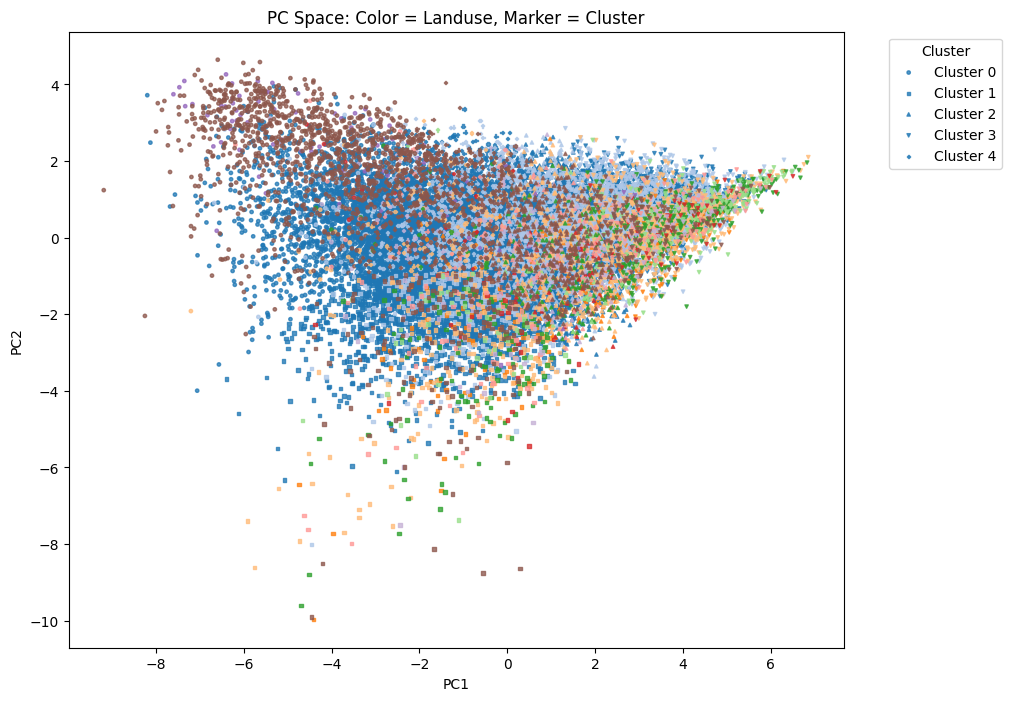

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# unique categories
landuse_classes = sorted(merged_df["LandUse"].unique())
clusters = sorted(merged_df["cluster"].unique())

# assign each landuse a color
cmap = plt.get_cmap("tab20")
color_map = {lu: cmap(i % 20) for i, lu in enumerate(landuse_classes)}

# assign each cluster a marker
markers = ["o", "s", "^", "v", "P", "D", "*", "X", "<", ">"]
marker_map = {cl: markers[i % len(markers)] for i, cl in enumerate(clusters)}

plt.figure(figsize=(10, 8))

for cl in clusters:
    subset = merged_df[merged_df["cluster"] == cl]
    plt.scatter(
        subset["pc1"],
        subset["pc2"],
        c=subset["LandUse"].map(color_map),
        marker=marker_map[cl],
        s=6,
        alpha=0.75,
        label=f"Cluster {cl}"
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PC Space: Color = Landuse, Marker = Cluster")

# legend for cluster markers
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.show()


01:23:07 | INFO | vacant_lots | Analyzing cluster composition by LandUse


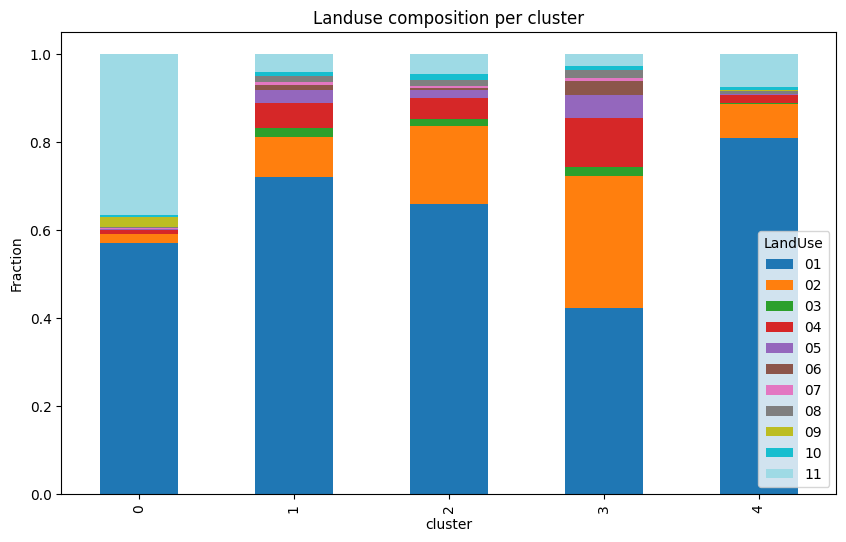

LandUse,01,02,03,04,05,06,07,08,09,10,11
cluster,,,,,,,,,,,
0,0.569641,0.021397,0.000000,0.008074,0.002019,0.000404,0.002826,0.003230,0.022204,0.004845,0.365361
1,0.719409,0.090884,0.020805,0.056666,0.029838,0.011771,0.006296,0.013961,0.000547,0.008760,0.041062
2,0.658948,0.177917,0.014129,0.048012,0.018184,0.004971,0.005756,0.011774,0.000916,0.012559,0.046834
3,0.422609,0.299517,0.020290,0.110725,0.054300,0.030145,0.008502,0.017585,0.000386,0.009275,0.026667
4,0.808042,0.078438,0.002151,0.016714,0.002648,0.000331,0.001489,0.005295,0.002151,0.008440,0.074301


In [13]:
# Analyze cluster composition using the analysis module
composition = analyze_cluster_composition(merged_df, cluster_col="cluster", category_col="LandUse")

composition.plot(kind="bar", stacked=True, figsize=(10,6), colormap="tab20")
plt.title("Landuse composition per cluster")
plt.ylabel("Fraction")
plt.show()

# Show the composition table
composition

In [ ]:
#vegetation fraction 
# Optional but safe:

# number of NAIP pixels in parcel

# vegetation fraction (proportion NDVI > 0.2 or SAVI > 0.25)

In [ ]:
# stats by explicit landuse
mappluto_22_gdb[mappluto_22_gdb["LandUse"] == "11"]["Shape_Area"].describe()
mean = mappluto_22_gdb[mappluto_22_gdb["LandUse"] == "11"]["Shape_Area"].mean()
std = mappluto_22_gdb[mappluto_22_gdb["LandUse"] == "11"]["Shape_Area"].std()

lower_bound = mean - std
upper_bound = mean + std

within_1std = mappluto_22_gdb[
    (mappluto_22_gdb["Shape_Area"] >= lower_bound) &
    (mappluto_22_gdb["Shape_Area"] <= upper_bound)
]
areas = within_1std["Shape_Area"]
within_1std["Shape_Area"].describe()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(areas, bins=100, color="skyblue", edgecolor="black", alpha=0.7)
plt.yscale("log")  # log scale helps reveal distribution
plt.xlabel("Parcel Area (sqft)")
plt.ylabel("Count (log scale)")
plt.title("Distribution of Vacant Lot Areas Within 1 Std dev (MapPLUTO)")

mean = areas.mean()
std = areas.std()
median = areas.median()
plt.axvline(mean, color="red", linestyle="--", label=f"Mean = {mean:.0f}")
plt.axvline(mean + std, color="orange", linestyle="--", label="+1 Std")
plt.axvline(mean - std, color="orange", linestyle="--", label="-1 Std")
plt.axvline(median, color="blue", linestyle="--", label="median")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# stats by NumBldgs, BldgArea, BuiltFar
# Due to LandUse counts
potential_vacant, lots_to_inspect, vacant_landuse_counts = identify_potential_vacant_lots(mappluto_22_gdb)
potential_vacant["Shape_Area"].describe()

In [ ]:
# Makes sense
# 7: Transportation and Utility
# 9: Open space and Outdoor Recreation
# 10: Parking Facilities
# Doesn't Really Make Sense
# 01,02,03,04,05: Buildings
# 08: Public Facilities and Institutions
# TODO kind of want to look at these lots in pictures
vacant_landuse_counts

In [ ]:
# Generate README for this run
from config import generate_run_readme

run_stats = {
    "Total parcels loaded": len(mappluto_22_gdf),
    "Sampled parcels": len(sampled_gdf),
    "Land use codes": sorted(sampled_gdf['LandUse'].unique()),
    "Unique clusters": len(merged_df['cluster'].unique()),
    "Total spectral features": len(CONFIG.clustering.features),
}

generate_run_readme(
    config=CONFIG,
    output_dir=CONFIG.get_output_dir(REPO_ROOT),
    stats=run_stats,
)